# HOMEWORK 6

The objective of this assignment is to detect the four corners of a document using the Harris corner detector and a custom-designed feature descriptor.


The solution is based on the following steps:

- The Harris corner detector is applied to identify candidate corner points in the image.

- A custom quadrant-based descriptor is designed to characterize the intensity structure around each candidate point.

- The descriptor evaluates the brightness relationships between four local quadrants in order to distinguish the four document corners.


In [1]:
import cv2
import math
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

(<Axes: >, <matplotlib.image.AxesImage at 0x71510c030d40>)

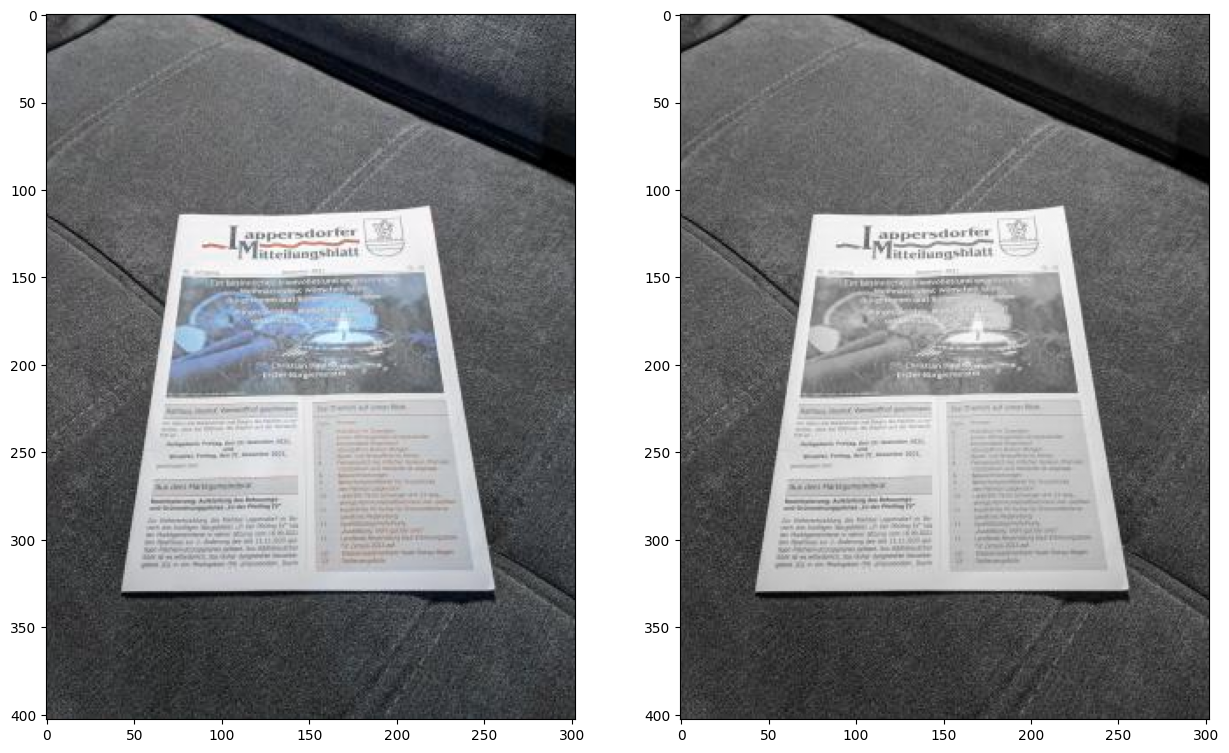

In [2]:
img = cv2.imread('data/document.jpg')

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray = np.float32(gray)/255
rows, cols = gray.shape

plt.subplot(121), plt.imshow(img)
plt.subplot(122), plt.imshow(gray, cmap='gray')

### Harris Corner Detector

In [ ]:
# Compute Harris corners
cornerness = cv2.cornerHarris(gray, blockSize=2, ksize=3, k=0.04)

# put to zero all negative cornerness values
cornerness = np.maximum(cornerness, 0)

cornerness = np.log(cornerness + 1e-6)

(<Axes: >, <matplotlib.image.AxesImage at 0x71510b9a2180>)

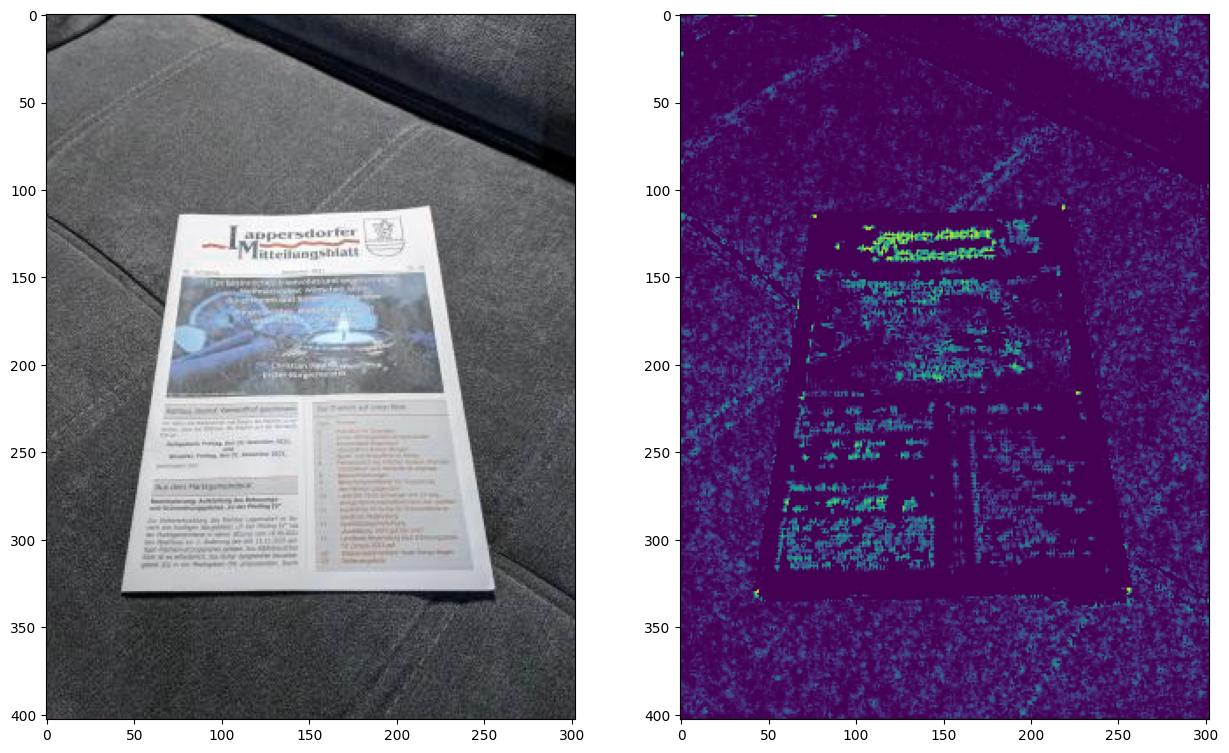

In [4]:
plt.subplot(121), plt.imshow(img)
plt.subplot(122), plt.imshow(cornerness)

Next, it is necessary to filter the points detected by the Harris detector, keeping only the four document corners. To achieve this, a custom feature descriptor is designed that analyzes the brightness in a local neighborhood: for the top-left corner, the descriptor verifies that the bottom-right quadrant is significantly brighter than the other three. The same approach is then applied to design descriptors for the remaining corners.


(<Axes: >, <matplotlib.image.AxesImage at 0x71510b9ce6c0>)

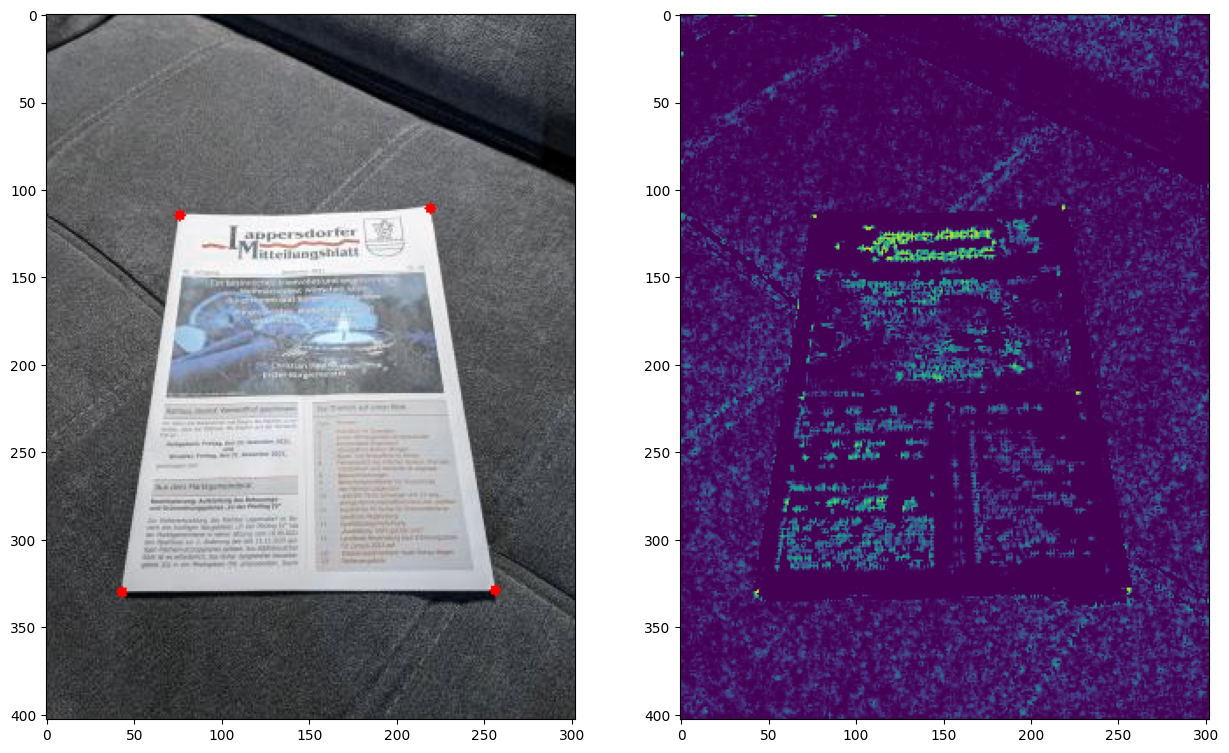

In [5]:
# Detection thresholds
th_top_left, th_top_right = -1e6, -1e6
th_bottom_left, th_bottom_right = -1e6, -1e6

# Corner coordinates
opt_top_left, opt_top_right = None, None
opt_bottom_left, opt_bottom_right = None, None

# Size of each quadrant (in pixels)
quad_size = 7

# The next step is to inspect the Harris detection results.
for r in range(quad_size, rows-quad_size):
    for c in range(quad_size, cols-quad_size):
        # Edges with too small cornerness score are discarded
        if cornerness[r, c] < -7:
            continue
        
        # Extract block consisting of 4 quadrants
        block = 255*gray[r-quad_size:r+quad_size+1, c-quad_size:c+quad_size+1]
        
        # Extract the four quandrants
        quad_top_left = block[0:quad_size, 0:quad_size]
        quad_top_right = block[0:quad_size, quad_size+1:2*quad_size+1]
        quad_bottom_left = block[quad_size+1:2*quad_size+1, 0:quad_size]
        quad_bottom_right = block[quad_size+1:2*quad_size+1, quad_size+1:2*quad_size+1]
        
        # Top-left corner
        descriptor = np.mean(quad_bottom_right) - \
                     np.mean(quad_top_left) - np.mean(quad_top_right) - np.mean(quad_bottom_left)
        if descriptor > th_top_left:
            th_top_left = descriptor
            opt_top_left = (c, r)
            
        # Top-right corner
        descriptor = np.mean(quad_bottom_left) - \
             np.mean(quad_top_left) - np.mean(quad_top_right) - np.mean(quad_bottom_right)
        if descriptor > th_top_right:
            th_top_right = descriptor
            opt_top_right = (c, r)
            
        # Bottom-left corner
        descriptor = np.mean(quad_top_right) - \
             np.mean(quad_top_left) - np.mean(quad_bottom_left) - np.mean(quad_bottom_right)
        if descriptor > th_bottom_left:
            th_bottom_left = descriptor
            opt_bottom_left = (c, r)
            
        # Bottom-right corner
        descriptor = np.mean(quad_top_left) - \
             np.mean(quad_top_right) - np.mean(quad_bottom_left) - np.mean(quad_bottom_right)
        if descriptor > th_bottom_right:
            th_bottom_right = descriptor
            opt_bottom_right = (c, r)

out = cv2.circle(img, opt_top_left, 3, (255,0,0), -1)
out = cv2.circle(img, opt_top_right, 3, (255,0,0), -1)
out = cv2.circle(img, opt_bottom_left, 3, (255,0,0), -1)
out = cv2.circle(img, opt_bottom_right, 3, (255,0,0), -1)

plt.subplot(121), plt.imshow(out)
plt.subplot(122), plt.imshow(cornerness)

## Questions

**1. Does it matter whether the picture was taken by a 1Mpx or 12Mpx camera?**

Yes, it matters. If the image has higher resolution (for example 12Mpx), the document corners contain more pixels. This can allow more precise localization. However, higher resolution also introduces more small details (such as text corners), which may increase the number of false detections.

Therefore, higher resolution can improve accuracy, but it can also increase noise and unwanted corner responses.

**2. If we increased the resolution of the camera, what would you change in the algorithm?**

If the resolution increases, the quadrant size (quad_size) should also increase.

When the image becomes larger, the physical document corner occupies more pixels. If the window size remains fixed, it may no longer describe the corner structure correctly.

Therefore, the window size should be scaled proportionally to the image size.

Optionally, a multi-scale approach (image pyramid) could be used. However, adapting the window size is a simpler and sufficient solution for this task.

## Algorithm Improvements

In [25]:
import cv2
import numpy as np

def detect_document_corners(img):

    if img is None:
        raise ValueError("Input image is None.")

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = np.float32(gray) / 255.0

    # ADDED: Gaussian smoothing to reduce small gradient noise before Harris
    gray = cv2.GaussianBlur(gray, (5,5), 0)

    rows, cols = gray.shape

    # ADDED: automatic document segmentation using Otsu thresholding
    gray_uint8 = (gray * 255).astype(np.uint8)
    _, mask = cv2.threshold(gray_uint8, 0, 255,
                            cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # ADDED: morphological closing to refine the document mask
    kernel = np.ones((5,5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

    cornerness = cv2.cornerHarris(gray, 2, 3, 0.04)
    cornerness = np.maximum(cornerness, 0)
    cornerness = np.log(cornerness + 1e-6)

    # CHANGED: adaptive threshold instead of fixed value (-7)
    threshold = np.percentile(cornerness, 99)

    # CHANGED: quadrant size scaled according to image resolution
    quad_size = int(0.01 * min(rows, cols))
    quad_size = max(5, min(quad_size, 25))

    th_top_left = -1e12
    th_top_right = -1e12
    th_bottom_left = -1e12
    th_bottom_right = -1e12

    opt_top_left = None
    opt_top_right = None
    opt_bottom_left = None
    opt_bottom_right = None

    for r in range(quad_size, rows - quad_size):
        for c in range(quad_size, cols - quad_size):

            # ADDED: restrict corner search to detected document region
            if mask[r, c] == 0:
                continue

            if cornerness[r, c] < threshold:
                continue

            block = gray[r-quad_size:r+quad_size+1,
                         c-quad_size:c+quad_size+1] * 255

            quad_top_left = block[0:quad_size, 0:quad_size]
            quad_top_right = block[0:quad_size, quad_size+1:2*quad_size+1]
            quad_bottom_left = block[quad_size+1:2*quad_size+1, 0:quad_size]
            quad_bottom_right = block[quad_size+1:2*quad_size+1, quad_size+1:2*quad_size+1]

            # Original quadrant-based descriptor retained
            descriptor = np.mean(quad_bottom_right) - \
                         np.mean(quad_top_left) - \
                         np.mean(quad_top_right) - \
                         np.mean(quad_bottom_left)
            if descriptor > th_top_left:
                th_top_left = descriptor
                opt_top_left = (c, r)

            descriptor = np.mean(quad_bottom_left) - \
                         np.mean(quad_top_left) - \
                         np.mean(quad_top_right) - \
                         np.mean(quad_bottom_right)
            if descriptor > th_top_right:
                th_top_right = descriptor
                opt_top_right = (c, r)

            descriptor = np.mean(quad_top_right) - \
                         np.mean(quad_top_left) - \
                         np.mean(quad_bottom_left) - \
                         np.mean(quad_bottom_right)
            if descriptor > th_bottom_left:
                th_bottom_left = descriptor
                opt_bottom_left = (c, r)

            descriptor = np.mean(quad_top_left) - \
                         np.mean(quad_top_right) - \
                         np.mean(quad_bottom_left) - \
                         np.mean(quad_bottom_right)
            if descriptor > th_bottom_right:
                th_bottom_right = descriptor
                opt_bottom_right = (c, r)

    return opt_top_left, opt_top_right, opt_bottom_left, opt_bottom_right


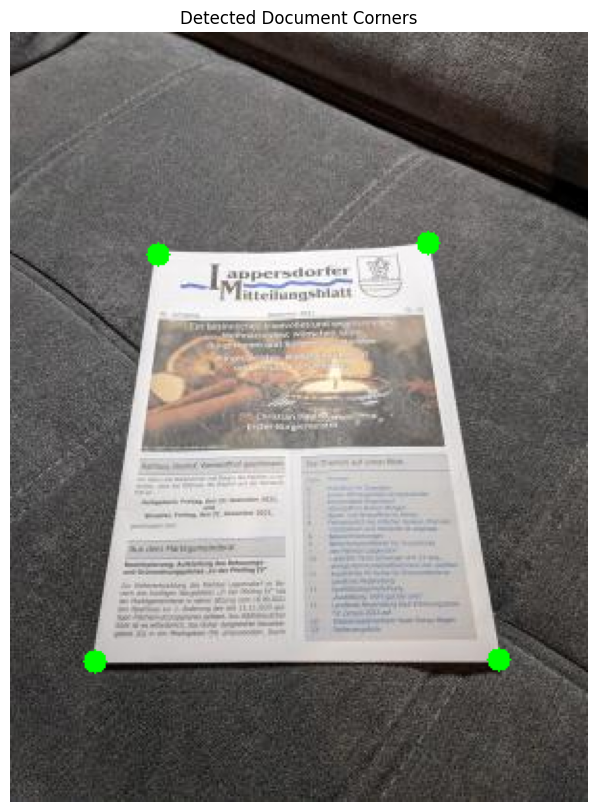

In [26]:
img = cv2.imread('data/document.jpg')

corners = detect_document_corners(img)

out = img.copy()

for pt in corners:
    if pt is not None:
        out = cv2.circle(out, pt, 6, (0,255,0), -1)

out_rgb = cv2.cvtColor(out, cv2.COLOR_BGR2RGB)

plt.imshow(out_rgb)
plt.title("Detected Document Corners")
plt.axis("off")
plt.show()

## Description of Improvements

The original Harris-based corner detection method was extended to improve robustness and reduce false detections.

First, Gaussian smoothing was applied before computing the Harris response to reduce small gradient noise.

Second, the search area was restricted to the bright document region obtained via Otsu thresholding. This prevents strong background edges from influencing the detection process. Morphological closing was applied to refine the document mask.

Third, the fixed Harris threshold was replaced by an adaptive percentile-based threshold. This makes the algorithm less sensitive to global contrast variations.

Finally, the quadrant size used in the custom descriptor was made proportional to the image resolution. This ensures scale consistency when processing images of different sizes.

The core Harris detector and quadrant-based descriptor were preserved, but the overall pipeline became more robust, structured, and resolution-aware.

Despite the improvements, some limitations remain. The algorithm currently selects a single global maximum descriptor for each corner type. This works well when the document clearly dominates the image, but in more complex scenes this strategy may fail if other strong corner-like structures are present. A more robust strategy сould be to retain multiple high-scoring candidate points and then select the final four corners based on their relative spatial positions in the image.

Additionally, document segmentation relies on Otsu thresholding. If the background is bright, Otsu may not correctly separate the document from the background, and a more robust segmentation method would be required.